In [1]:
!git clone https://github.com/gotec/git2net-tutorials
import os
os.chdir('git2net-tutorials')
!pip install -r requirements.txt
os.chdir('..')

fatal: destination path 'git2net-tutorials' already exists and is not an empty directory.


In [2]:
import git2net
import networkx as nx
import matplotlib.pyplot as plt
import shutil
import sqlite3
import pandas as pd
from collections import Counter, defaultdict
import pathpy as pp
from datetime import timedelta
import numpy as np

# git2net @ MSR 2023

This is a 40-min tutorial prepared for the 20th International Conference on Mining Software Repositories (MSR 2023) held on the 15-16th of May 2023 in Melbourne, Australia.

## The Basics

Wary of the short time, let's jump right in:

In [3]:
github_url = 'gotec/git2net'
git_repo_dir = 'git2net4analysis'
sqlite_db_file = 'git2net4analysis.db'

# Remove the clone of the repository if it already exists from a previous run
if os.path.exists(git_repo_dir):
    shutil.rmtree(git_repo_dir)

# Remove resulting sqlite database if it already exists from a previous run
if os.path.exists(sqlite_db_file):
    os.remove(sqlite_db_file)

[2023-05-01 18:59:24]  git2net:INFO       Found no database on provided path. Starting from scratch.
Parallel (32 processes): 100%|██████████| 333/333 [00:14<00:00, 22.29it/s]


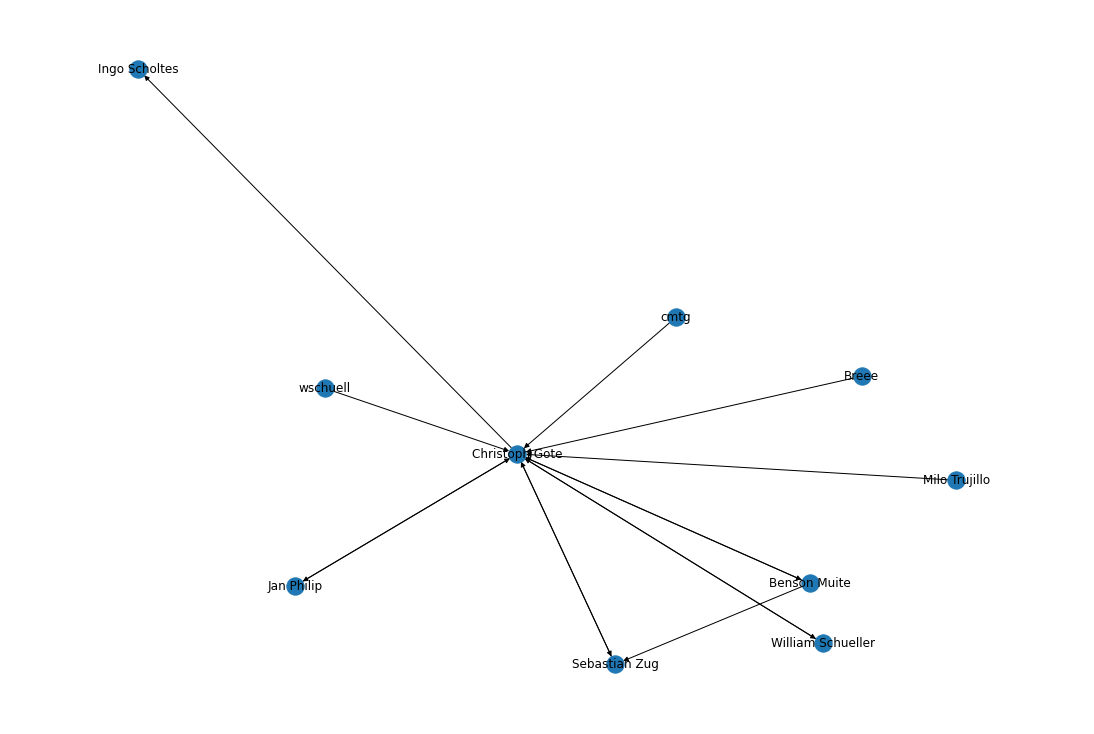

In [4]:
# Call git2net
git2net.mine_github(github_url, git_repo_dir, sqlite_db_file)
n, node_info, edge_info = git2net.get_coediting_network(sqlite_db_file,
                                                        author_identifier='author_name',
                                                        engine='networkx')

# Visualise the result
plt.figure(figsize=(15,10))
nx.draw(n, with_labels=True)
plt.margins(x=.1)

Congratulations, you have just mined and visualised your first repository using `git2net`!

So what did we just do?
The function `git2net.mine_github()` clones a given repository from GitHub and mines it's content.
Next to repositories from GitHub, `git2net` also works on all other git repositories.
To mine these, simply create a local clone yourself and call `git2net`'s mining function:

In [5]:
git2net.mine_git_repo(git_repo_dir, sqlite_db_file)

[2023-05-01 18:59:40]  git2net:INFO       All commits have already been mined!
[2023-05-01 18:59:40]  git2net:INFO       Updated branch information for mined commits in the active branch.


This also shows a core feature of `git2net`. It is able to seamlessly resume mining from a previously mined repository.
But what happens during mining?

In [6]:
from IPython.display import IFrame
IFrame("./figures/mining.pdf", width=900, height=450)

Mining a repository with `git2net` yields an SQLite database that contains three tables: `_metadata`, `commits`, and `edits`.
The table `_metadata` contains information such as the path to the original repository, the time it was mined, and the settings for `git2net` that were used.

In [7]:
with sqlite3.connect(sqlite_db_file) as con:
    commit_data = pd.read_sql_query("SELECT * FROM _metadata", con)

commit_data.tail()

,created with,repository,date,method,extract_text
0,git2net 1.6.1,https://github.com/gotec/git2net,2023-05-01 18:59:24,lines,False


The table `commits` stores all information related to the commits themselves, e.g., information regarding the author and time, the branch(es) in which it appears, and their parent-commit(s).
All commits are uniquely identified by their hash.

In [8]:
with sqlite3.connect(sqlite_db_file) as con:
    commit_data = pd.read_sql_query("SELECT * FROM commits", con)

commit_data.tail()

,hash,author_email,author_name,committer_email,committer_name,author_date,committer_date,author_timezone,committer_timezone,no_of_modifications,commit_message_len,project_name,parents,merge,in_main_branch,branches
328,0d3038ee7581e358ccc7fd551e18c60914e945f3,gotec@me.com,Christoph Gote,gotec@me.com,Christoph Gote,2020-04-22 14:20:36,2020-04-22 14:20:36,0,0,1,32,git2net4analysis,23f26b519e913580d02c7755f7617125683a784f,0,1,main
329,6b837c8f5383d16434afa0eaaab347873113230b,cgote@ethz.ch,Christoph Gote,cgote@ethz.ch,Christoph Gote,2019-09-23 16:32:25,2019-09-23 16:32:25,-7200,-7200,6,47,git2net4analysis,d32df107ed2d75c741726e88e39ba8b3f46b146f,0,1,main
330,23f26b519e913580d02c7755f7617125683a784f,gotec@me.com,Christoph Gote,gotec@me.com,Christoph Gote,2020-04-22 14:08:21,2020-04-22 14:08:21,0,0,6,57,git2net4analysis,9c03d52e0763d860b57c822161bc4383a702f5a4,0,1,main
331,4b081bb10e700a68f9d989b1186d4cab677456d3,gotec@me.com,Christoph Gote,gotec@me.com,Christoph Gote,2021-09-21 16:20:59,2021-09-21 16:20:59,0,0,1,23,git2net4analysis,7547d6716c301d437be8a53aa203fa41bd82fa5c,0,1,main
332,7547d6716c301d437be8a53aa203fa41bd82fa5c,gotec@me.com,Christoph Gote,gotec@me.com,Christoph Gote,2021-09-21 15:17:36,2021-09-21 15:17:36,0,0,1,32,git2net4analysis,5a66f1bbca68ea8d9c28403faaf0a227c138a113,0,1,main


Each commit may contain multiple files, each including numerous changes to lines.
These changes are reflected in the `edits` table, which contains detailed information about all modifications of the files contained in the commits.
Here `git2net` distinguishes between different file-level modifications (`modification_type`) and the corresponding line-level edits within files (`edit_type`).

A file included in a commit may be an added (`ADD`), deleted (`DELETE`), or modified (`MODIFY`) file.
In addition, changes to individual lines are saved for each file.
These can be newly added (`addition`), changed (`replacement`) or deleted (`deletion`) lines.

In [9]:
with sqlite3.connect(sqlite_db_file) as con:
    commit_data = pd.read_sql_query("SELECT * FROM edits", con)

commit_data.tail()

,commit_hash,edit_type,filename,levenshtein_dist,modification_type,new_path,old_path,original_commit_addition,original_commit_deletion,original_file_path_addition,...,post_entropy,post_len_in_chars,post_len_in_lines,post_starting_line_no,pre_entropy,pre_len_in_chars,pre_len_in_lines,pre_starting_line_no,total_added_lines,total_removed_lines
43937,7547d6716c301d437be8a53aa203fa41bd82fa5c,addition,TUTORIAL.ipynb,7,MODIFY,TUTORIAL.ipynb,TUTORIAL.ipynb,None,None,None,...,1.148835,7.0,1.0,3680.0,NaN,NaN,NaN,NaN,3205.0,93.0
43938,7547d6716c301d437be8a53aa203fa41bd82fa5c,addition,TUTORIAL.ipynb,34,MODIFY,TUTORIAL.ipynb,TUTORIAL.ipynb,None,None,None,...,3.645711,34.0,1.0,3681.0,NaN,NaN,NaN,NaN,3205.0,93.0
43939,7547d6716c301d437be8a53aa203fa41bd82fa5c,addition,TUTORIAL.ipynb,5,MODIFY,TUTORIAL.ipynb,TUTORIAL.ipynb,None,None,None,...,0.721928,5.0,1.0,3682.0,NaN,NaN,NaN,NaN,3205.0,93.0
43940,7547d6716c301d437be8a53aa203fa41bd82fa5c,addition,TUTORIAL.ipynb,5,MODIFY,TUTORIAL.ipynb,TUTORIAL.ipynb,None,None,None,...,1.370951,5.0,1.0,3683.0,NaN,NaN,NaN,NaN,3205.0,93.0
43941,7547d6716c301d437be8a53aa203fa41bd82fa5c,replacement,TUTORIAL.ipynb,1,MODIFY,TUTORIAL.ipynb,TUTORIAL.ipynb,None,2fb8a779e90b5ed1865922c749b33ec5155b9818,None,...,3.535175,21.0,1.0,3728.0,3.535175,21.0,1.0,616.0,3205.0,93.0


## Author Disambiguation

Some of you may have may have spotted an issue with the network I presented in the very beginning.
Going back and looking at it in more detail, we observe that one user appears twice.
This is obviously an issue.
Let's assume that we want to study the relationship between team size and team productivity like we did in a paper presented at ICSE last year (doi.org/10.1145/3510003.3510619).
If we were to split all authors into two identities we would double the size of the team and halve the producvity of each member (on average).
So how can we avoid this?
Using `git2net` for our own research on a daily basis, we wanted to make this process as simple as possible:

In [10]:
git2net.disambiguate_aliases_db(sqlite_db_file, method='gambit', thresh=.45)

with sqlite3.connect(sqlite_db_file) as con:
    authors = pd.read_sql("""SELECT author_name, author_email, author_id FROM commits""", con)

Counter(['{} --- {}, <{}>'.format(row.author_id, row.author_name, row.author_email)
         for idx, row in authors.iterrows()])

author identity disambiguation: 100%|██████████| 66/66 [00:00<00:00, 4218.85it/s]


Counter({'0 --- Ingo Scholtes, <scholtes@ifi.uzh.ch>': 8,
         '0 --- Ingo Scholtes, <ischoltes@ethz.ch>': 2,
         '1 --- Christoph Gote, <gotec@me.com>': 162,
         '1 --- Christoph Gote, <cgote@ethz.ch>': 139,
         '2 --- Jan Philip, <jan.philip.wahle@gmail.com>': 1,
         '3 --- Sebastian Zug, <Sebastian.Zug@informatik.tu-freiberg.de>': 2,
         '4 --- Breee, <loeffler.uni@gmail.com>': 1,
         '5 --- Milo Trujillo, <milo-trujillo@users.noreply.github.com>': 1,
         '6 --- Benson Muite, <bkmgit@users.noreply.github.com>': 11,
         '7 --- William Schueller, <william.schueller@gmail.com>': 4,
         '7 --- wschuell, <wschuell@users.noreply.github.com>': 1,
         '8 --- cmtg, <christian.gut@usp.br>': 1})

Next to our disambiguation algorithm `gambit` (doi.org/10.1109/MSR52588.2021.00021), `git2net` also supports the algorithms from Goeminne and Mens (`method='simple'`, doi.org/10.1016/j.scico.2011.11.004) and Bird et al. (`method='bird'`, doi.org/10.1145/1137983.1138016).
Try those for yourself!

## Network Analysis and Visualisation

So much on the mining part.
Let's now look at the network that we obtained with the second call in our short example (`git2net.get_coediting_network()`)

In [11]:
from IPython.display import IFrame
IFrame("./figures/coediting_network_creation.pdf", width=900, height=700)

Before, we were looking at the static network visualisation. Let's now have a look at the temporal network shown in the middle.

For this example, we will use a rolling time window spanning 365 days, which we then shift in 30-day increments.
We can use the `RollingTimeWindow()` function in `pathpy` to compute the networks over time.
Then, we only need to add the statistics of interest to a dictionary and plot them.

<AxesSubplot:xlabel='time'>

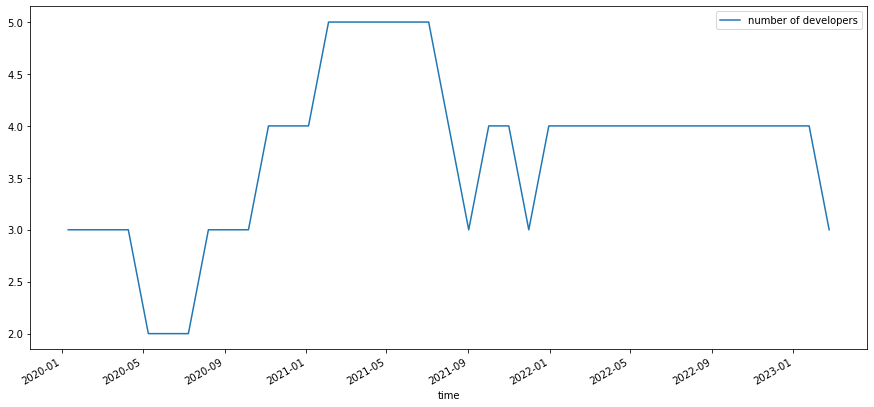

In [12]:
n_coediting_t, node_info, edge_info = git2net.get_coediting_network(sqlite_db_file)

WINDOW_SIZE = 365*24*60*60
STEP_SIZE = 30*24*60*60

data = defaultdict(list)
for network, window in pp.RollingTimeWindow(n_coediting_t,
                                            window_size=WINDOW_SIZE,
                                            step_size=STEP_SIZE,
                                            directed=True, return_window=True):
    data['number of developers'].append(network.ncount())
    data['time'].append(window[1]) # append window end time

df = pd.DataFrame(data, columns=list(data.keys()))
df.set_index(pd.to_datetime(df.time, unit='s'), inplace=True)
df.drop('time', axis=1, inplace=True)

df.plot(y='number of developers', figsize=(15,7))

## Database Analysis: Code Ownership

Let's next look at the database that `git2net` creates.
Specifically, we will look at an exemplary analysis on how the editing of own and foreign code evolves in the repository of `git2net`, similarly to the analyses we performed here (doi.org/10.1007/s10664-020-09928-2).

To do so, we first get the required data from the SQLite database.
Then, we join the two resulting data frames to get a single one containing information about how much code of whom and when.

In [13]:
with sqlite3.connect(sqlite_db_file) as con:
    edits = pd.read_sql("""SELECT
                               commit_hash,
                               original_commit_deletion,
                               levenshtein_dist
                           FROM edits
                           WHERE edit_type=='replacement'""", con).drop_duplicates()
    commits = pd.read_sql("""SELECT
                                 hash,
                                 author_id,
                                 author_date
                             FROM commits""", con)
    
edit_info = pd.merge(edits, commits, how='left', left_on='commit_hash', right_on='hash') \
              .drop(columns=['commit_hash', 'hash'])

edit_info = pd.merge(edit_info, commits, how='left', left_on='original_commit_deletion',
                     right_on='hash', suffixes=('', '_before')) \
              .drop(columns=['original_commit_deletion', 'hash', 'author_date_before'])

edit_info = edit_info[['author_id_before', 'author_id', 'author_date', 'levenshtein_dist']]

edit_info.index = pd.DatetimeIndex(edit_info.author_date)
edit_info = edit_info.drop(columns=['author_date'])

edit_info

,author_id_before,author_id,levenshtein_dist
author_date,,,
2019-01-08 14:30:15,0,0,30
2019-01-08 14:30:15,0,0,12
2019-01-08 14:30:15,0,0,40
2019-01-08 14:30:15,0,0,3
2019-01-08 14:30:15,0,0,27
...,...,...,...
2021-09-21 15:17:36,1,1,12
2021-09-21 15:17:36,1,1,231
2021-09-21 15:17:36,3,1,2


Now, we can compute the Levenshtein distances for changes in both own and foreign code for a rolling time window.
In a final step, we normalise them to allow a better comparison and plot them over time.

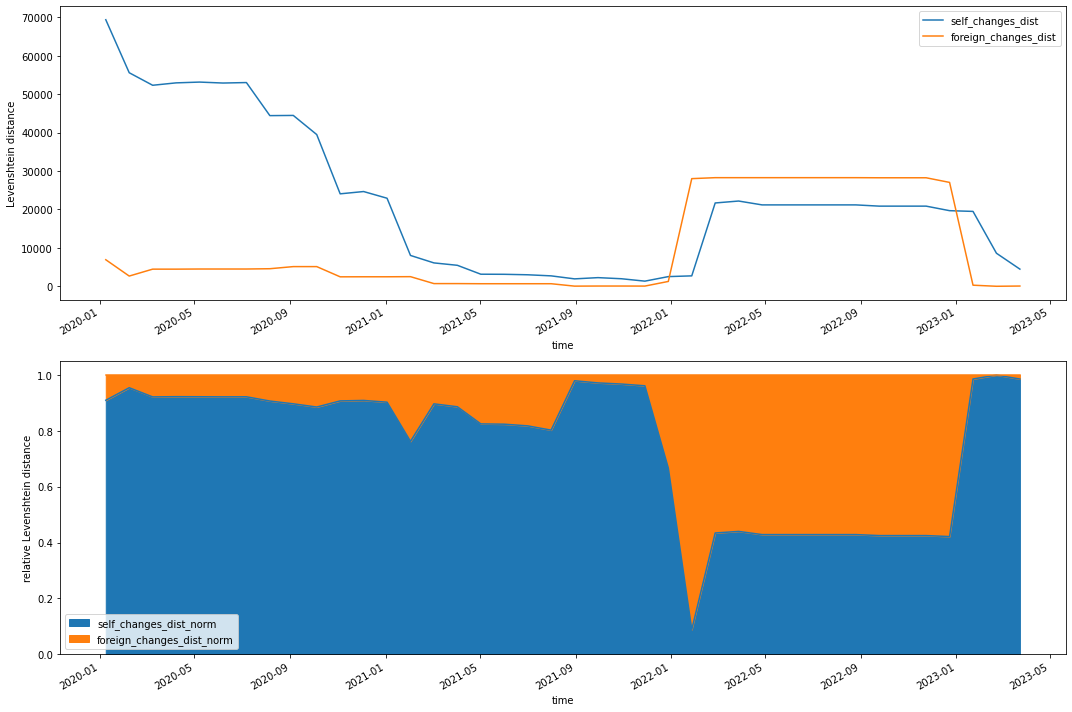

In [14]:
windowsize = timedelta(days=365)
increment = timedelta(days=30)

plot_data = defaultdict(list)

time = min(edit_info.index) + windowsize
while time < max(edit_info.index):
    mask = (edit_info.index > time - windowsize) & (edit_info.index <= time)
    wdata = edit_info.loc[mask]
    self_changes_dist = 0
    foreign_changes_dist = 0
    for idx, row in wdata.iterrows():
        self_changes_dist += row['levenshtein_dist'] * (row['author_id_before'] == row['author_id'])
        foreign_changes_dist += row['levenshtein_dist'] * (row['author_id_before'] != row['author_id'])
    plot_data['time'].append(time)
    plot_data['self_changes_dist'].append(self_changes_dist)
    plot_data['foreign_changes_dist'].append(foreign_changes_dist)
    time += increment


plot_data['self_changes_dist_norm'] = [s / (s + f) for s, f in zip(plot_data['self_changes_dist'],
                                                                   plot_data['foreign_changes_dist'])]
plot_data['foreign_changes_dist_norm'] = [f / (s + f) for s, f in zip(plot_data['self_changes_dist'],
                                                                      plot_data['foreign_changes_dist'])]

plot_data = pd.DataFrame(plot_data)

plt.figure(figsize=(15,10))
ax = plt.subplot(2,1,1)
plot_data.plot(x='time', y=['self_changes_dist', 'foreign_changes_dist'], ax=ax, ylabel="Levenshtein distance")

ax = plt.subplot(2,1,2)
plot_data.plot(x='time', y=['self_changes_dist_norm', 'foreign_changes_dist_norm'], kind='area', ax=ax,
               ylabel="relative Levenshtein distance")
plt.tight_layout()
plt.show()

As you can see, code ownership in the repository of `git2net` is very high.
However, this should be expected as, as we saw earlier, most of the code is written by a single person.
With minor modifications to the code above, you can also figure out how much code each contributor owns at every point in time.

`git2net` also works with the git repositories behind [Overleaf projects](https://www.overleaf.com/).
So go ahead and try it with your most recent paper :)

## Complexity Analysis

Finally, let's look at code complexity.
By calling the function `git2net.compute_complexity()` we can now create a new table `complexity` in our database which contains the complexity of all modified files for all commits.
Let's create this table and have a look at what it contains.

In [15]:
git2net.compute_complexity(git_repo_dir, sqlite_db_file)

with sqlite3.connect(sqlite_db_file) as con:
    complexity = pd.read_sql("SELECT * FROM complexity", con)
    
complexity.head()

complexity computation: 100%|██████████| 528/528 [00:13<00:00, 37.80it/s] 


,commit_hash,old_path,new_path,events,levenshtein_distance,HE_pre,HE_post,HE_delta,CCN_pre,CCN_post,CCN_delta,NLOC_pre,NLOC_post,NLOC_delta,TOK_pre,TOK_post,TOK_delta,FUN_pre,FUN_post,FUN_delta
0,00931359c800da3d7679bac92866f9d5cc567e12,git2net/__init__.py,git2net/__init__.py,1,1.0,227.938136,245.622991,17.684855,0,0,0,21,22,1,83,89,6,0,0,0
1,090c00c342283134a23900f85c1d232499617365,_test_extract_edits.py,None,40,1234.0,12054.167135,0.000000,-12054.167135,0,0,0,28,0,-28,176,0,-176,0,0,0
2,090c00c342283134a23900f85c1d232499617365,_test_get_original_line_number.py,None,75,1795.0,35826.527730,0.000000,-35826.527730,0,0,0,47,0,-47,339,0,-339,0,0,0
3,090c00c342283134a23900f85c1d232499617365,_test_get_unified_changes.py,None,14,220.0,355.353126,0.000000,-355.353126,0,0,0,7,0,-7,38,0,-38,0,0,0
4,03c7e1674606e0540b3bc2df79db38d075f1ce7b,git2net/__init__.py,git2net/__init__.py,1,1.0,76.865555,76.865555,0.000000,0,0,0,20,20,0,75,75,0,0,0,0


To see how code complexity changes for the `git2net`project, we create a dataframe listing the absolute changes in complexity for all contributors to `git2net` over time. 

In [16]:
with sqlite3.connect(sqlite_db_file) as con:
    complexity = pd.read_sql("""SELECT commit_hash,
                                       events,
                                       levenshtein_distance,
                                       HE_delta,
                                       CCN_delta,
                                       NLOC_delta,
                                       TOK_delta,
                                       FUN_delta
                                FROM complexity""", con)

# We compute the absolute differences.
complexity['HE_absdelta'] = np.abs(complexity.HE_delta)
complexity['CCN_absdelta'] = np.abs(complexity.CCN_delta)
complexity['NLOC_absdelta'] = np.abs(complexity.NLOC_delta)
complexity['TOK_absdelta'] = np.abs(complexity.TOK_delta)
complexity['FUN_absdelta'] = np.abs(complexity.FUN_delta)

complexity.groupby(['commit_hash']) \
          .agg({'events': 'sum',
                'levenshtein_distance': 'sum',
                'HE_absdelta': 'sum',
                'CCN_absdelta': 'sum',
                'NLOC_absdelta': 'sum',
                'TOK_absdelta': 'sum',
                'FUN_absdelta': 'sum'}).reset_index()
    
complexity.drop(columns=['HE_delta', 'CCN_delta', 'NLOC_delta', 'TOK_delta',
                         'FUN_delta'], inplace=True)    
  
# We add a counter for the commits.
complexity['commits'] = 1
    
with sqlite3.connect(sqlite_db_file) as con:
    commits = pd.read_sql("SELECT hash, author_date, author_id FROM commits", con)

complexity = pd.merge(complexity, commits, left_on='commit_hash', right_on='hash', how='left')
complexity = complexity.set_index(pd.DatetimeIndex(complexity['author_date']))
complexity = complexity.sort_index()
complexity.drop(columns=['hash', 'commit_hash', 'author_date'], inplace=True)

complexity.head()

,events,levenshtein_distance,HE_absdelta,CCN_absdelta,NLOC_absdelta,TOK_absdelta,FUN_absdelta,commits,author_id
author_date,,,,,,,,,
2019-01-08 10:58:20,147,4504.0,137718.254426,17,104,745,3,1,0
2019-01-08 14:30:15,51,1758.0,19065.779916,1,1,53,0,1,0
2019-01-08 17:42:58,123,3605.0,130405.815591,9,26,158,1,1,0
2019-01-08 19:48:13,93,2342.0,39438.313217,1,8,81,0,1,0
2019-01-09 12:22:27,142,4688.0,240414.231259,9,59,613,3,1,0


We can then plot these changes, e.g., as cumulative sums as shown below.

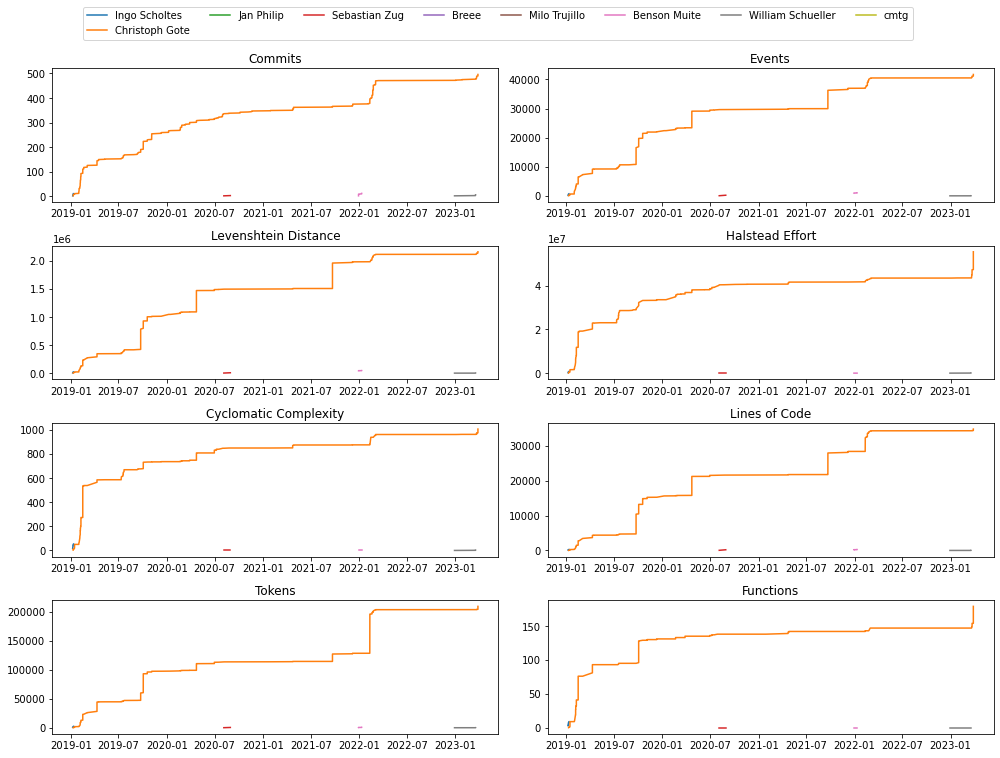

In [17]:
with sqlite3.connect(sqlite_db_file) as con:
    commits = pd.read_sql("SELECT author_name, author_id FROM commits", con)

commits.drop_duplicates(inplace=True)
    
author_id_name_map = {}
for idx, group in commits.groupby('author_id'):
    author_id_name_map[idx] = list(group.author_name)

fig, axs = plt.subplots(4,2, figsize=(14,10))

axs[0,0].set_title('Commits')
axs[0,1].set_title('Events')
axs[1,0].set_title('Levenshtein Distance')
axs[1,1].set_title('Halstead Effort')
axs[2,0].set_title('Cyclomatic Complexity')
axs[2,1].set_title('Lines of Code')
axs[3,0].set_title('Tokens')
axs[3,1].set_title('Functions')

for author_id, group in complexity.groupby(['author_id']):
    group_cs = group.cumsum()
    axs[0,0].plot(group_cs.index, group_cs.commits, label=author_id_name_map[author_id][0])
    axs[0,1].plot(group_cs.index, group_cs.events)
    axs[1,0].plot(group_cs.index, group_cs.levenshtein_distance)
    axs[1,1].plot(group_cs.index, group_cs.HE_absdelta)
    axs[2,0].plot(group_cs.index, group_cs.CCN_absdelta)
    axs[2,1].plot(group_cs.index, group_cs.NLOC_absdelta)
    axs[3,0].plot(group_cs.index, group_cs.TOK_absdelta)
    axs[3,1].plot(group_cs.index, group_cs.FUN_absdelta)

plt.tight_layout()
axs[0,0].legend(loc='upper center', bbox_to_anchor=(1, 1.5), ncol=8)
plt.show()

Try this out for your own repository!
Can you create a similar plot with a rolling window instead of the cumulative sum?

With this, we conclude this tutorial on `git2net`.
We hope you found it interesting and helpful.
If you did, you can find a broad range of more detailed tutorials on `git2net` at https://github.com/gotec/git2net-tutorials.
You can also find a full documentation at https://git2net.readthedocs.io/en/latest/.

Enjoy using `git2net`, and best of luck with your research!
If you have any feedback or find bugs within the code, please let us know at https://github.com/gotec/git2net.